## Домашка (10 баллов)


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


In [1]:
%pip install --upgrade keras
%pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 3.0.4 which is incompatible.


In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/lenta_40k.csv.zip')

In [6]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [7]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [8]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [9]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [10]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

X = keras.utils.pad_sequences(X, maxlen=MAX_LEN)

In [11]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [12]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [27]:
# CNN 4 layers for testings

inputs = keras.layers.Input(shape = (MAX_LEN, ))
embeddings = keras.layers.Embedding(input_dim = len(word2id), output_dim = 30) (inputs)
dropout1 = keras.layers.Dropout(0.1) (embeddings)
conv1 = keras.layers.Conv1D(kernel_size = 5, filters = 32, strides = 1) (dropout1)
flatten = keras.layers.Flatten() (conv1)
dense = keras.layers.Dense(32, activation = 'relu') (flatten)

outputs = keras.layers.Dense(len(label2id), activation = 'softmax') (dense)

model = keras.Model(inputs = inputs, outputs = outputs)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
              metrics = [keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [28]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)         │ (None, 200)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ embedding_5 (Embedding)            │ (None, 200, 30)               │     722,760 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_5 (Dropout)                │ (None, 200, 30)               │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d_5 (Conv1D)                  │ (None, 196, 32)               │       4,832 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_4 (Flatten)                │ (None, 6272)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_8 (Dense)                    │ (None, 32)                    │     200,736 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_9 (Dense)                    │ (None, 19)                    │         627 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 928,955 (3.54 MB)

 Trainable params: 928,955 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.1871 - rec@prec: 0.0126 - val_loss: 0.1045 - val_rec@prec: 0.4991
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0865 - rec@prec: 0.6011 - val_loss: 0.0741 - val_rec@prec: 0.6709
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0427 - rec@prec: 0.8850 - val_loss: 0.0814 - val_rec@prec: 0.6858
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0193 - rec@prec: 0.9756 - val_loss: 0.1022 - val_rec@prec: 0.6740
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 0.0078 - rec@prec: 0.9958 - val_loss: 0.1298 - val_rec@prec: 0.6483
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0041 - rec@prec: 0.9985 - val_loss: 0.1375 - val_rec@prec: 0.6650
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 0.0024 - rec@prec: 0.9997 - val_loss: 0.1536 - val_rec@prec: 0.6835
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0019 - rec@prec: 0.9996 - val_loss: 0.1636 - val_rec@prec:

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


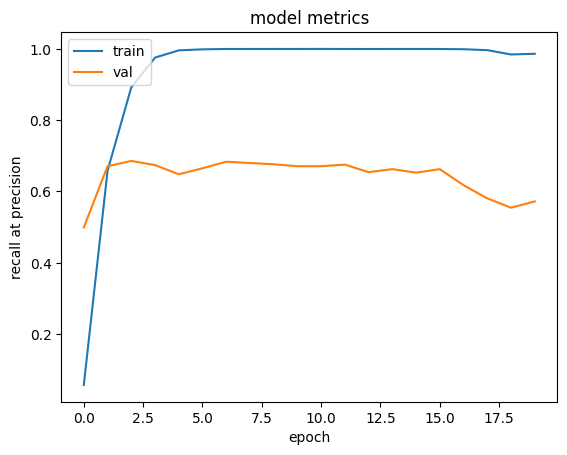

In [30]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
# NN 9 layers testing

inputs = keras.layers.Input(shape = (MAX_LEN, ))
embeddings = keras.layers.Embedding(input_dim = len(word2id), output_dim = 100) (inputs)
dropout = keras.layers.Dropout(0.1) (embeddings)

convs = []

for ks in [5, 7, 10]:
  conv1 = keras.layers.Conv1D(kernel_size=ks, filters=64, padding='same', strides=1) (embeddings)
  pooling1 = keras.layers.AveragePooling1D(pool_size=5)(conv1)

  conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same', strides=1,
                              kernel_regularizer='l2', activation='relu') (pooling1)
  pooling2 = keras.layers.AveragePooling1D(pool_size=10) (conv2)

  dropout1 = keras.layers.Dropout(0.1) (pooling2)

  conv3 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same', strides=1) (dropout1)

  convs.append(conv3)

concat = keras.layers.concatenate(convs, axis=1)
conv_global1 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1) (concat)
flatten = keras.layers.Flatten() (conv_global1)
dense = keras.layers.Dense(100, activation='relu') (flatten)

outputs = keras.layers.Dense(len(label2id), activation='softmax') (dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics = [keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])



In [50]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 200)            │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ embedding_21 (Embedding)  │ (None, 200, 100)       │  2,409,200 │ input_layer_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_98 (Conv1D)        │ (None, 200, 64)        │     32,064 │ embedding_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_101 (Conv1D)       │ (None, 200, 64)        │     44,864 │ embedding_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_104 (Conv1D)       │ (None, 200, 64)        │     64,064 │ embedding_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_56      │ (None, 40, 64)         │          0 │ conv1d_98[0][0]            │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_58      │ (None, 40, 64)         │          0 │ conv1d_101[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_60      │ (None, 40, 64)         │          0 │ conv1d_104[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_99 (Conv1D)        │ (None, 40, 32)         │     10,272 │ average_pooling1d_56[0][0] │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_102 (Conv1D)       │ (None, 40, 32)         │     14,368 │ average_pooling1d_58[0][0] │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_105 (Conv1D)       │ (None, 40, 32)         │     20,512 │ average_pooling1d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_57      │ (None, 4, 32)          │          0 │ conv1d_99[0][0]            │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_59      │ (None, 4, 32)          │          0 │ conv1d_102[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_61      │ (None, 4, 32)          │          0 │ conv1d_105[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dropout_48 (Dropout)      │ (None, 4, 32)          │          0 │ average_pooling1d_57[0][0] │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ dropout_49 (Dropout)      │ (None, 4, 32)          │          0 │ average_pooling1d_59[0][0] │
├──────────────────────

 Total params: 2,650,739 (10.11 MB)

 Trainable params: 2,650,739 (10.11 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 370s 17s/step - loss: 1.2707 - rec@prec: 7.9710e-06 - val_loss: 0.7585 - val_rec@prec: 0.0000e+00
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 397s 18s/step - loss: 0.6545 - rec@prec: 2.3478e-05 - val_loss: 0.4098 - val_rec@prec: 0.0000e+00
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 412s 19s/step - loss: 0.3604 - rec@prec: 1.4621e-04 - val_loss: 0.2428 - val_rec@prec: 4.5086e-04
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 320s 15s/step - loss: 0.2181 - rec@prec: 0.0336 - val_loss: 0.1559 - val_rec@prec: 0.2020
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 319s 14s/step - loss: 0.1430 - rec@prec: 0.2471 - val_loss: 0.1134 - val_rec@prec: 0.4436


dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


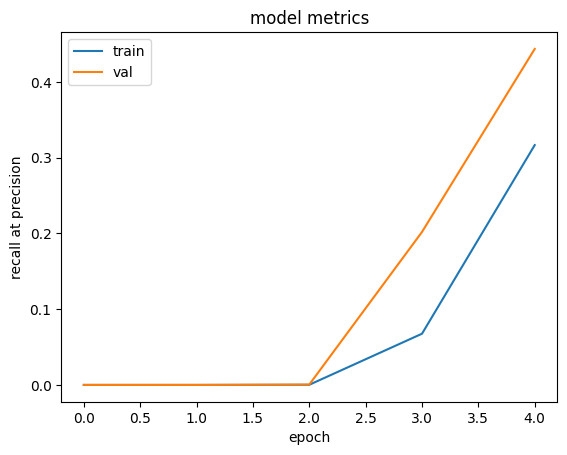

In [52]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
# NN 15 layers and callbacks

inputs = keras.layers.Input(shape = (MAX_LEN, ))
embeddings = keras.layers.Embedding(input_dim = len(word2id), output_dim = 100) (inputs)
dropout = keras.layers.Dropout(0.1) (embeddings)

convs = []

for ks in [3, 5, 7, 10]:
  conv1 = keras.layers.Conv1D(kernel_size=ks,
                              filters=64,
                              padding='same',
                              strides=1) (embeddings)

  pooling1 = keras.layers.AveragePooling1D(pool_size=5)(conv1)

  conv2 = keras.layers.Conv1D(kernel_size=ks,
                              filters=32,
                              padding='same',
                              strides=1,
                              kernel_regularizer='l2',
                              activation='relu') (pooling1)

  pooling2 = keras.layers.AveragePooling1D(pool_size=10) (conv2)

  dropout1 = keras.layers.Dropout(0.1) (pooling2)

  conv3 = keras.layers.Conv1D(kernel_size=ks,
                              filters=32,
                              padding='same',
                              strides=1) (dropout1)

  convs.append(conv3)

concat = keras.layers.concatenate(convs, axis=1)

conv4 = keras.layers.Conv1D(kernel_size=5,
                            filters=32,
                            strides=2)(concat)

pooling4 = keras.layers.AveragePooling1D(pool_size=5)(conv4)

conv6 = keras.layers.Conv1D(kernel_size=5,
                            filters=32,
                            strides=5)(pooling4)

pooling5 = keras.layers.AveragePooling1D(pool_size=5)(conv6)

flatten1 = keras.layers.Flatten()(pooling5)

dense1 = keras.layers.Dense(100, activation='relu')(concat)

conv7 = keras.layers.Conv1D(kernel_size=5,
                            filters=32,
                            strides=1) (dense1)

flatten2 = keras.layers.Flatten() (conv7)

dense2 = keras.layers.Dense(100, activation='relu') (flatten2)
outputs = keras.layers.Dense(len(label2id), activation='softmax') (dense2)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics = [keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [65]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31            │ (None, 200)            │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ embedding_29 (Embedding)  │ (None, 200, 100)       │  2,409,200 │ input_layer_31[0][0]       │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_205 (Conv1D)       │ (None, 200, 64)        │     19,264 │ embedding_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_208 (Conv1D)       │ (None, 200, 64)        │     32,064 │ embedding_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_211 (Conv1D)       │ (None, 200, 64)        │     44,864 │ embedding_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_214 (Conv1D)       │ (None, 200, 64)        │     64,064 │ embedding_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_126     │ (None, 40, 64)         │          0 │ conv1d_205[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_128     │ (None, 40, 64)         │          0 │ conv1d_208[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_130     │ (None, 40, 64)         │          0 │ conv1d_211[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_132     │ (None, 40, 64)         │          0 │ conv1d_214[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_206 (Conv1D)       │ (None, 40, 32)         │      6,176 │ average_pooling1d_126[0][… │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_209 (Conv1D)       │ (None, 40, 32)         │     10,272 │ average_pooling1d_128[0][… │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_212 (Conv1D)       │ (None, 40, 32)         │     14,368 │ average_pooling1d_130[0][… │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ conv1d_215 (Conv1D)       │ (None, 40, 32)         │     20,512 │ average_pooling1d_132[0][… │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_127     │ (None, 4, 32)          │          0 │ conv1d_206[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ average_pooling1d_129     │ (None, 4, 32)          │          0 │ conv1d_209[0][0]           │
│ (AveragePooling1D)        │                        │            │                            │
├──────────────────────

 Total params: 8,118,791 (30.97 MB)

 Trainable params: 2,706,263 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,412,528 (20.65 MB)

In [67]:
# callbacks

checkpoint = keras.callbacks.ModelCheckpoint('model.weights.keras',
                                             monitor='val_loss',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max',
                                             save_freq='epoch'
                                             )
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.01,
                                           patience=3,
                                           verbose=1,
                                           mode='max')


In [70]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0074 - rec@prec: 0.9971 
Epoch 1: val_loss improved from 0.16777 to 0.17832, saving model to model.weights.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 387s 17s/step - loss: 0.0074 - rec@prec: 0.9971 - val_loss: 0.1783 - val_rec@prec: 0.6023
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0060 - rec@prec: 0.9978 
Epoch 2: val_loss improved from 0.17832 to 0.18397, saving model to model.weights.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 386s 18s/step - loss: 0.0061 - rec@prec: 0.9978 - val_loss: 0.1840 - val_rec@prec: 0.6010
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0053 - rec@prec: 0.9984 
Epoch 3: val_loss improved from 0.18397 to 0.19617, saving model to model.weights.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 387s 18s/step - loss: 0.0053 - rec@prec: 0.9984 - val_loss: 0.1962 - val_rec@prec: 0.5920
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0050 - rec@prec: 0.9981 
Epoch 4: val_loss improved from 0.19617 to 0.

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


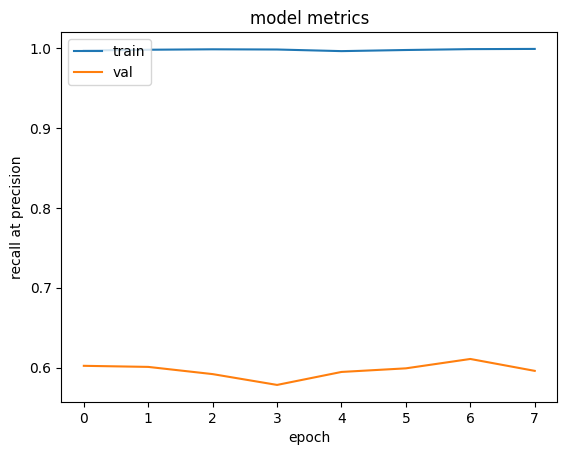

In [71]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# учил сначала 10 эпох - плохо, 20 - тоже не особо